In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def get_argmax(Q):
    maxim = Q[0]-1
    for i in range(4):
        if Q[i] > maxim:
            index = []
            index.append(i)
            maxim = Q[i]
        elif Q[i] == maxim:
            index.append(i)
    return index[np.random.randint(0,len(index)+0.5)]

def rand_entry(L):
    len_list = len(L)
    return L[np.random.randint(len_list)]

def eps_greedy_selection(arr,epsilon):
    if np.random.rand()>epsilon:
        return get_argmax(arr)
    else:
        return np.random.randint(4)

In [17]:
#class for the realization of the maze
class dyna_maze:
    
    #initialize the maze
    def __init__(self, start_state, goal_state, obstructions):
        self.grid = np.zeros((6,9))
        self.start = start_state
        self.goal = goal_state
        for s in obstructions:
            self.grid[s] = 1
        
class agent:
    
    def __init__(self, dyna_maze):
        self.maze = dyna_maze
        #action 1 is right, 2 is down, 3 is left, 4 is up
        self.action_coords = [(0,1),(1,0),(0,-1),(-1,0)]
        self.restart()
        
    def restart(self):
        self.state = self.maze.start
    
    def take_action(self, action):
        updated_state = (self.state[0] + self.action_coords[action][0],self.state[1] + self.action_coords[action][1])
        if updated_state[0] < 6 and updated_state[1] < 9:
            if updated_state[0] >= 0 and updated_state[1] >= 0:
                if self.maze.grid[updated_state] == 0:
                    self.state = updated_state
        if updated_state == self.maze.goal:
            return 1
        else:
            return 0
    
    
    def dyna_q(self, alpha, gamma, epsilon,nr_episodes,n):
        Q = np.zeros((6,9,4))
        model = np.zeros((6,9,4), dtype = 'i,i,i')
        episode_steps_arr = []
        
        for k in range(nr_episodes):
            self.restart()
           
            episode_steps = 0
            visited_states = []
            actions_taken = np.frompyfunc(list, 0, 1)(np.empty((6,9), dtype=object))
            
            while True:
                episode_steps +=1
                
                S = self.state
                if S not in visited_states:
                    visited_states.append(S)

                A = eps_greedy_selection(Q[S],epsilon)
                
                if A not in actions_taken[S]:
                    actions_taken[S].append(A)
                R = self.take_action(A)
                a_max = get_argmax(Q[self.state])
                
                
                Q[S][A] = Q[S][A] + alpha*(R + gamma*Q[self.state][a_max] - Q[S][A])
                model[S][A] = (self.state[0], self.state[1], R)
            
                for j in range(n):
                    S = rand_entry(visited_states)
                    A = rand_entry(actions_taken[S])
                    R = model[S][A][2]
                    S_prime = (model[S][A][0],model[S][A][1])
                    a_max = get_argmax(Q[S_prime])
                    Q[S][A] = Q[S][A] + alpha*(R + gamma*Q[S_prime][a_max] - Q[S][A])
                
                if R == 1:
                    episode_steps_arr.append(episode_steps)
                    break
            
        return episode_steps_arr
    
    def n_sarsa(self,alpha, gamma, epsilon,nr_episodes,n):
        Q = np.zeros((6,9,4))
        episode_steps_arr = []
        
        for k in range(nr_episodes):
            self.restart()
            S = self.state
            T = 1e20
            t = 0
            episode_steps = 0
            states_arr = [S]
            rewards_arr = [None]
            
            A = eps_greedy_selection(Q[S],epsilon)
            
            actions_arr = [A]
            
            while True:
                if t < T:
                    episode_steps += 1
                    R = self.take_action(A)
                    rewards_arr.append(R)
                    states_arr.append(self.state)
                    if R == 1:
                        T = t+1
                    else:
                        A = eps_greedy_selection(Q[self.state],epsilon)
                        actions_arr.append(A)
                
                tau = t - n + 1
               
                if tau >=0:
                    G = 0
                    for i in range(tau+1,min(tau+n,T)+1):
                        G += gamma**(i-tau-1)*rewards_arr[i]
                    if tau+n < T:
                        G = G + gamma**n*Q[states_arr[tau+n]][actions_arr[tau+n]]
                    Q[states_arr[tau]][actions_arr[tau]] += alpha*(G -Q[states_arr[tau]][actions_arr[tau]])
            
                t += 1
                
                if tau == T-1:
                    episode_steps_arr.append(episode_steps)
                    break  
                    
        return episode_steps_arr
                    
    def plot_dyna(self, alpha, gamma, epsilon,nr_episodes,n_arr):
        for n in n_arr:
            sum_arr = np.zeros(nr_episodes)
            for k in range(30):
                episode_steps_arr = self.dyna_q(alpha, gamma, epsilon,nr_episodes,n)
                arr = np.array(episode_steps_arr)
                sum_arr = sum_arr + arr
            x = [i for i in range(1,nr_episodes+1)]
            plt.plot(x,sum_arr/30, label = '{} planning steps'.format(n))
        plt.xlabel('Episodes')
        plt.ylabel('Steps per Episode')
        plt.legend()
        plt.savefig('dyna.jpg')
        plt.show()
        
    def plot_sarsa(self, alpha, gamma, epsilon,nr_episodes,n_arr):
        for n in n_arr:
            sum_arr = np.zeros(nr_episodes)
            for k in range(30):
                episode_steps_arr = self.n_sarsa(alpha, gamma, epsilon,nr_episodes,n)
                arr = np.array(episode_steps_arr)
                sum_arr = sum_arr + arr
            x = [i for i in range(1,nr_episodes+1)]
            plt.plot(x,sum_arr/30, label = '{}-step SARSA'.format(n))
        plt.xlabel('Episodes')
        plt.ylabel('Steps per Episode')
        plt.legend()
        plt.savefig('sarsa.jpg')
        plt.show()

In [18]:
start_state = (2,0)
goal_state = (0,8)
obstructions = [(1,2),(2,2),(3,2),(4,5),(0,7),(1,7),(2,7)]

maze = dyna_maze(start_state,goal_state,obstructions)

print(maze.grid)

[[0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [19]:
new_ag = agent(maze)

<IPython.core.display.Javascript object>


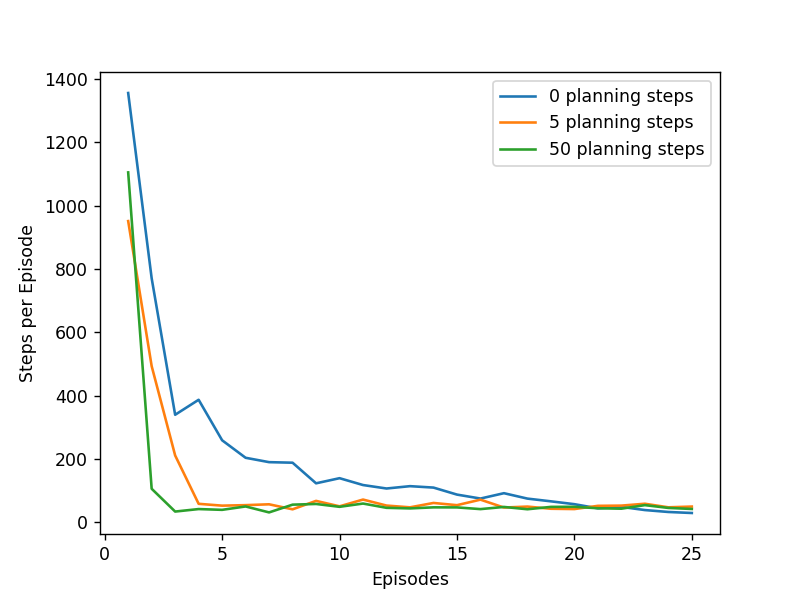

In [20]:
%matplotlib notebook

new_ag.plot_dyna(0.1,0.95,0.1,25,[0,5,50])

<IPython.core.display.Javascript object>


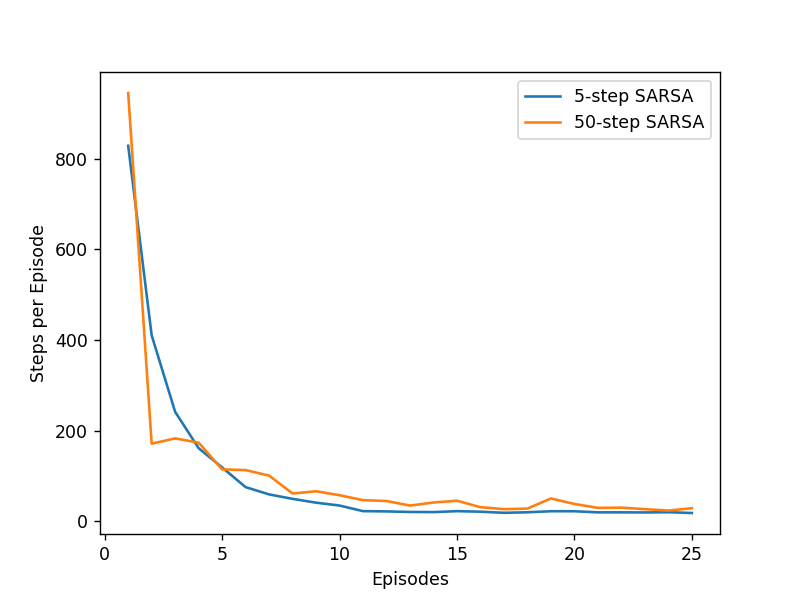

In [12]:
%matplotlib notebook

new_ag.plot_sarsa(0.1,0.95,0.1,25,[5,50])